# LIGHTGBM
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
from glob import glob
import pickle
import chime
import logging

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import swifter

from utils import *

from Functions import getSentinelBandFile

#import optuna.integration.lightgbm as lgb


In [15]:
def calcMeanDiffs(df, headers):
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["BaseMean"] = df.apply(lambda r: np.mean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False, verbosity=0, suffix="_"):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50, verbose=verbosity)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    #scores["Kappa"] = cohen_kappa_score(Y_valid, preds)
    #scores["accuracy"] = accuracy_score(Y_valid, preds)
    #scores["AUC"] = auc(Y_valid, preds)
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-3]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}_{suffix}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}_{suffix}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "num_leaves": trial.suggest_int("num_leaves", 50, 3000), # increasing leave max from 500 to 3k on 2021-11-29 as i reduce max-depth
        "max_depth": trial.suggest_int("max_depth", 3, 12), # changing from 10 to 100 to 3 to 12. LGBM is supposed to be shallow and per blog, most successful models don't exceed 12
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        #"num_iterations": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        #"boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 700), # 2021-09-16 upped from 500 to 700. Previous fit picked 498
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 100), #introducing on 2021-06-11. apparently used to control overfitting. Will the optimizer use it?
        "reg_lambda": trial.suggest_float("reg_alpha", 1e-5, 100), #introducing on 2021-09-09. apparently used to control overfitting. Will the optimizer use it?
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col, verbosity=-1)
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True

In [3]:
trainingSamples_locs = {'PondLake': '../OtherData/TrainingData/PondLake_20210519.pickle',
                        'Pool': '../OtherData/TrainingData/Pool_20210519.pickle',
                        'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210519.pickle',
                        'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210519.pickle',
                        'Asphault': '../OtherData/TrainingData/Asphault_20210519.pickle',
                        'Impervious': '../OtherData/TrainingData/Impervious_20210519.pickle',
                        'Structure': '../OtherData/TrainingData/Structure_20210519.pickle',
                        'Barren': '../OtherData/TrainingData/Barren_20210519.pickle',
                        'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210519.pickle',
                        'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210519.pickle',
                        'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle',
                        'BarrenUrban': '../OtherData/TrainingData/BarrenUrban_20210825.pickle'
                       }

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5,
                      'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9,
                      "ParkingLot": 7, "Sidewalk": 8, "BarrenUrban": 3}

for lcclass, fileloc in trainingSamples_locs.items():
    trainingSamples_locs[lcclass] = fileloc.replace("20210519", "20210825")
trainingSamples_locs

trainingSamples_locs

{'PondLake': '../OtherData/TrainingData/PondLake_20210825.pickle',
 'Pool': '../OtherData/TrainingData/Pool_20210825.pickle',
 'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210825.pickle',
 'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210825.pickle',
 'Asphault': '../OtherData/TrainingData/Asphault_20210825.pickle',
 'Impervious': '../OtherData/TrainingData/Impervious_20210825.pickle',
 'Structure': '../OtherData/TrainingData/Structure_20210825.pickle',
 'Barren': '../OtherData/TrainingData/Barren_20210825.pickle',
 'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210825.pickle',
 'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210825.pickle',
 'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210825.pickle',
 'BarrenUrban': '../OtherData/TrainingData/BarrenUrban_20210825.pickle'}

In [4]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or "Barren" in lcClass or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        #df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        #df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
            
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
    
    print(lcClass, len(df))
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)
trainingSamples = trainingSamples[~(trainingSamples.RED == 0) & ~(trainingSamples.GREEN == 0) & ~(trainingSamples.BLUE == 0) & ~(trainingSamples.NIR == 0)]

print(f"{len(trainingSamples)} total samples")

trainingSamples[class_col] = trainingSamples['LCClass'].apply(lambda lcc: values_2019_lookup[lcc])

%chime

PondLake 3454380
Pool 4437801
DenseVeg 4141512
IrrigatedLand 4649042
Asphault 4805230
Impervious 4972560
Structure 4751827
Barren 4704748
SparseVeg 5159379
ParkingLot 2527684
Sidewalk 1053586
BarrenUrban 3987757
48645006 total samples


pix_counts_2015 = {"Water": 717101, "Trees/Shrubs": 238776309, "Irrigated": 79004633, "Desert": 1140416988, "Barren": 165940209, "Impervious": 16819231, "Structure":10348374, "Road":603552}
#values_2015 = {1:, 2:, 3: , 4:, 5:, 6:, 7:, 8:}

ratios_2015 = {}
valid_pix = 0
for k,v in pix_counts_2015.items():
    valid_pix += v
for k, v in pix_counts_2015.items():
    ratios_2015[k] = round(v/valid_pix, 10)
    #print(k, v/valid_pix, totals[k]/num_pix)
print(ratios_2015)

In [5]:
trainingFeaturesToUse = trainingSamples.columns.tolist()
#trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "GaussianSigma5" not in fn]
#trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "Segment_" not in fn]
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

In [6]:
sindicies = ["NDWI", "BSI", "NDVI", "NDVIa", "DBSI", "NDMI"]
sbands = [2, 3, 4, 5, 6, 7, 8, "8A", 11, 12]

sentinel_bands, sentinel_indicies = {}, {}
for b in sbands:
    band = f"B0{b}" if len(str(b)) == 1 else f"B{b}"
    sentinel_bands[band] = getSentinelBandFile(band, "../Sentinel2Data")
for index in sindicies:
    sentinel_indicies[index] = getSentinelBandFile(index, "../Sentinel2Data")
sentinel_bands, sentinel_indicies

({'B02': '../Sentinel2Data\\B02Mean_20190601to20190901_2868.tif',
  'B03': '../Sentinel2Data\\B03Mean_20190601to20190901_2868.tif',
  'B04': '../Sentinel2Data\\B04Mean_20190601to20190901_2868.tif',
  'B05': '../Sentinel2Data\\B05Mean_20190601to20190901_2868.tif',
  'B06': '../Sentinel2Data\\B06Mean_20190601to20190901_2868.tif',
  'B07': '../Sentinel2Data\\B07Mean_20190601to20190901_2868.tif',
  'B08': '../Sentinel2Data\\B08Mean_20190601to20190901_2868.tif',
  'B8A': '../Sentinel2Data\\B8AMean_20190601to20190901_2868.tif',
  'B11': '../Sentinel2Data\\B11Mean_20190601to20190901_2868.tif',
  'B12': '../Sentinel2Data\\B12Mean_20190601to20190901_2868.tif'},
 {'NDWI': '../Sentinel2Data\\NDWI_Sentinel2_20190601to20190901.tif',
  'BSI': '../Sentinel2Data\\BSI_Sentinel2_20190601to20190901.tif',
  'NDVI': '../Sentinel2Data\\NDVIa_Sentinel2_20190601to20190901.tif',
  'NDVIa': '../Sentinel2Data\\NDVIa_Sentinel2_20190601to20190901.tif',
  'DBSI': '../Sentinel2Data\\DBSI_Sentinel2_20190601to20190901

In [7]:
%%time
subGroups = []
sampleSize = 20000
overwrite = False
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification
subSampleFile_template = f"../OtherData/TrainingData/SubSampleGroup%s_{sampleSize}.pickle"
sentinel_prefix = "Sentinel2_"

for i in range(5):
    start = datetime.now()
    subSampleFile = subSampleFile_template % i
    if not os.path.exists(subSampleFile) or overwrite:
        trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
        trainingSamples_sub["RGBNmean"] = trainingSamples_sub.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
        trainingSamples_sub["geometry"] = trainingSamples_sub.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
        for files_dict in [sentinel_bands, sentinel_indicies]:
            for name, file in files_dict.items():
                column_name = f"{sentinel_prefix}{name}"
                print(f"Working {column_name}")
                with rio.open(file) as src:
                    trainingSamples_sub[column_name] = trainingSamples_sub["geometry"].swifter.apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                    
        del trainingSamples_sub["X"], trainingSamples_sub["Y"], trainingSamples_sub["geometry"]
        trainingSamples_sub.to_pickle(subSampleFile)
    else:
        trainingSamples_sub = pd.read_pickle(subSampleFile)

    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")


%chime
trainingFeaturesToUse = subGroups[0].columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")
#trainingFeaturesToUse.remove("X")
#trainingFeaturesToUse.remove("Y")
#trainingFeaturesToUse.append("RGBNmean")
#trainingFeaturesToUse += [sentinel_prefix + k for k in sentinel_bands.keys()]
#trainingFeaturesToUse += [sentinel_prefix + k for k in sentinel_indicies.keys()]
featureHeaders = trainingFeaturesToUse[:]
featureHeaders

Done 0 - 0:00:00.287354
Done 1 - 0:00:00.223351
Done 2 - 0:00:00.299906
Done 3 - 0:00:00.231933
Done 4 - 0:00:00.229818
Wall time: 1.27 s


['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR',
 'GaussianSigma5_RED',
 'GaussianSigma5_GREEN',
 'GaussianSigma5_BLUE',
 'GaussianSigma5_NIR',
 'Segment_area',
 'Segment_extent',
 'Segment_eccentricity',
 'Segment_perimeter',
 'RED_LHE',
 'GREEN_LHE',
 'BLUE_LHE',
 'NIR_LHE',
 'RGBNmean',
 'Sentinel2_B02',
 'Sentinel2_B03',
 'Sentinel2_B04',
 'Sentinel2_B05',
 'Sentinel2_B06',
 'Sentinel2_B07',
 'Sentinel2_B08',
 'Sentinel2_B8A',
 'Sentinel2_B11',
 'Sentinel2_B12',
 'Sentinel2_NDWI',
 'Sentinel2_BSI',
 'Sentinel2_NDVI',
 'Sentinel2_NDVIa',
 'Sentinel2_DBSI',
 'Sentinel2_NDMI']

In [25]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.025, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 42, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 25, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 10.47, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 0.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 11, 
                           'Impervious': 3, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 8} # dropping to 8 from 14.88 on 2021-08-28

# replace human readable names with numerical associations
local_class_weight_dict = { values_2019_lookup[k]: v/100 for k, v in local_class_weight_dict.items() }

print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")


fixed_params = {
    "objective": "multiclass",
    "num_iterations": 200,
    "early_stopping_rounds": 20, # changed from 75 to 50 on 2021-06-02. Potential speed up and possible overfitting at 75. Down to 40 on 2021-09-16. Back to 20 (%10 of num_iterations) on 2021-11-29
    "bagging_freq": 5, # increasing bagging_frequency from 5 on 2021-06-11. Hopefully help with overfitting. Back to 5 on 2021-09-16
    #"bagging_fraction": 0.75, # Hard setting this on 2021-06-11. Hope to help with overfitting
    "min_data_in_leaf": 20,#int(0.005*sampleSize), # increasing to 1% of sampleSize from 0.5% on 2021-06-11. Hopefully make more generalized. Dropping to .5% from 1% on 2021-11-04
    "n_jobs": 8,
    "random_state": 7,
    "verbose": -1,
    "class_weight": local_class_weight_dict,
    "boosting_type": "gbdt", # every optimized model trained over two months picked gbdt over rf. setting to fixed
    "min_split_gain": 0.01 # min_split_gain at 0 means no improvement is too small. Setting this 0.01 on 2021-06-11. hopefully speed up fitting
    #"max_depth": len(featureHeaders) # set this on 2021-09-09. Removed from fixed on 9-16 ("tune num_leaves with the max depth together")
}


Sum of weights: 1.0001499999999999


In [17]:
%%time

resume = False
tday = "20211129"
study_name = f"OptunaTuner_MultiClass_{tday}"
study_loc = f"Models/{study_name}.db"
storage_loc = f"sqlite:///{study_loc}"
history_loc = f"Models/History_{study_name}.feather"
    
if not resume and os.path.exists(study_loc):
    print("Study resume not set and study already exists. Removing")
    os.remove(study_loc)
    
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(
    study_name=study_name,
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    direction="maximize",
    storage=storage_loc,
    load_if_exists=True)

study.optimize(optunaObjective, n_trials=200, n_jobs=3)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
%chime

Study resume not set and study already exists. Removing


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.390563
Early stopping, best iteration is:
[38]	valid_0's F1: 0.436821
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.391665
Early stopping, best iteration is:
[42]	valid_0's F1: 0.440715
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.46685
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.390488
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.4401

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.524909
Early stopping, best iteration is:
[86]	valid_0's F1: 0.397524
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's F1: 0.43548
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[89]	valid_0's F1: 0.39996


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	valid_0's F1: 0.439782
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.52999


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[119]	valid_0's F1: 0.66185
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.438212
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's F1: 0.52779
Early stopping, best iteration is:
[97]	valid_0's F1: 0.665908
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's F1: 0.434222
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's F1: 0.439723


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[120]	valid_0's F1: 0.660264
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	valid_0's F1: 0.52934
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's F1: 0.657611
Early stopping, best iteration is:
[167]	valid_0's F1: 0.410593
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's F1: 0.530987
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[182]	valid_0's F1: 0.417016
Early stopping, best iteration is:
[132]	valid_0's F1: 0.6631
Early stopping, best iteration is:
[112]	valid_0's F1: 0.527716
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's F1: 0.530254
Early stopping, best iteration is:
[173]	valid_0's F1: 0.416191


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0214025
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.432566
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0213518
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0216346
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0214025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	valid_0's F1: 0.417657
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0216263
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.436035
Early stopping, best iteration is:
[139]	valid_0's F1: 0.419046
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's F1: 0.434298
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's F1: 0.4379
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.657365
Early stopping, best iteration is:
[13]	valid_0's F1: 0.434608
Early stopping, best iteration is:
[142]	valid_0's F1: 0.433485
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's F1: 0.430885
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's F1: 0.439675


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's F1: 0.426725
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	valid_0's F1: 0.411082
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.659502
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's F1: 0.436739


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[142]	valid_0's F1: 0.413119
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.659672
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's F1: 0.413979
Early stopping, best iteration is:
[119]	valid_0's F1: 0.82934
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[181]	valid_0's F1: 0.410923
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.657022
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.830607
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stoppin

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's F1: 0.854144
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.840024
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.660949
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's F1: 0.674472
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	valid_0's F1: 0.848785
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.677931
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	valid_0's F1: 0.837236
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's F1: 0.678271
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's F1: 0.842628
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's F1: 0.676269
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's F1: 0.67818


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's F1: 0.853719
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.673418
Early stopping, best iteration is:
[171]	valid_0's F1: 0.842338
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.673123
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's F1: 0.607667
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.851919
Early stopping, best iteration is:
[23]	valid_0's F1: 0.676224


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.629191
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.673534
Early stopping, best iteration is:
[32]	valid_0's F1: 0.626835
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.634707
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's F1: 0.674659


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.631426
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's F1: 0.623997
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.637002
Early stopping, best iteration is:
[23]	valid_0's F1: 0.630164
Early stopping, best iteration is:
[52]	valid_0's F1: 0.633841


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.624795
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.640122
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.642474
Early stopping, best iteration is:
[28]	valid_0's F1: 0.637387


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's F1: 0.641474
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's F1: 0.622772
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[81]	valid_0's F1: 0.648728
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.629791
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's F1: 0.63122
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's F1: 0.637971
Early stopping, best iteration is:
[88]	valid_0's F1: 0.644771


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's F1: 0.633764
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's F1: 0.632494
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's F1: 0.643471
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's F1: 0.629391
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.640787
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.651319
Early stopping, best iteration is:
[70]	valid_0's F1: 0.632696


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of arg

Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.643735
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.673821
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.635943
Early stopping, best iteration is:
[35]	valid_0's F1: 0.675614
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.533181
Early stopping, best iteration is:
[62]	valid_0's F1: 0.675458
Early stopping, best iteration is:
[84]	valid_0's F1: 0.646536
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.674201
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.675989


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's F1: 0.887702
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's F1: 0.535773
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[157]	valid_0's F1: 0.600812
Early stopping, best iteration is:
[106]	valid_0's F1: 0.886272
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[186]	valid_0's F1: 0.537156
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[120]	valid_0's F1: 0.612802
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[89]	valid_0's F1: 0.884608
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[142]

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.537889
Early stopping, best iteration is:
[125]	valid_0's F1: 0.607729


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	valid_0's F1: 0.604825
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.670938
Early stopping, best iteration is:
[71]	valid_0's F1: 0.675093
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	valid_0's F1: 0.607423
Early stopping, best iteration is:
[89]	valid_0's F1: 0.673615
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[95]	valid_0's F1: 0.67438
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[102]	valid_0's F1: 0.674092
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.671834
Early 

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[43]	valid_0's F1: 0.671726
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.645643
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's F1: 0.608045


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.654714
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.657459
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.650556
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[179]	valid_0's F1: 0.663637
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.659616
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.643222
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.658706
Early stopping, best iteration is:
[32]	valid_0's F1: 0.640945


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.65812
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's F1: 0.665278
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.660672


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.63056
Early stopping, best iteration is:
[64]	valid_0's F1: 0.762103
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[149]	valid_0's F1: 0.667257
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.738718
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	valid_0's F1: 0.661475
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.763289
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.635222
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	va

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.773688


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.635378
Early stopping, best iteration is:
[63]	valid_0's F1: 0.918443
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	valid_0's F1: 0.91363
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	valid_0's F1: 0.919071
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.632629
Early stopping, best iteration is:
[69]	valid_0's F1: 0.909044
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's F1: 0.91885
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.920174
Early stopping, best iteration is:
[81]	valid_0's F1: 0.911377


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's F1: 0.858006
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's F1: 0.665687
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	valid_0's F1: 0.912826


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[34]	valid_0's F1: 0.662128
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's F1: 0.865313
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's F1: 0.664015
Early stopping, best iteration is:
[52]	valid_0's F1: 0.665646
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's F1: 0.662829
Early stopping, best iteration is:
[58]	valid_0's F1: 0.659826
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[98]	valid_0's F1: 0.86116
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.664503
Early st

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.425953
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.65844
Early stopping, best iteration is:
[90]	valid_0's F1: 0.85772
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.430577
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's F1: 0.426731
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's F1: 0.66418


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.424083
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's F1: 0.865428
Early stopping, best iteration is:
[7]	valid_0's F1: 0.429721


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[43]	valid_0's F1: 0.52281
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.525028
Early stopping, best iteration is:
[53]	valid_0's F1: 0.523025
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.529248
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's F1: 0.52712
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's F1: 0.524573
Early stopping, best iteration is:
[38]	valid_0's F1: 0.519191
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's F1: 0.528113
Early stopping, best iteration is:
[32]	valid_0's F1: 0.52

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's F1: 0.521435
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.524451
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	valid_0's F1: 0.529362
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.663277


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[154]	valid_0's F1: 0.527041
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.66778
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.669964
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.663658
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[185]	valid_0's F1: 0.523801
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's F1: 0.670161
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.663904
Training until validation scores don't impr

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[175]	valid_0's F1: 0.660773
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[143]	valid_0's F1: 0.417171
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.499544
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.660891


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	valid_0's F1: 0.418952
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.499277
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[122]	valid_0's F1: 0.641629
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[123]	valid_0's F1: 0.419327
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[120]	valid_0's F1: 0.645408
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.497703
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[122]	valid_0's F1: 0.417722
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	valid_0's F1: 0.643201
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.433788
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's F1: 0.440455
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	valid_0's F1: 0.647976
Early stopping, best iteration is:
[52]	valid_0's F1: 0.441593
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.495673


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.429688
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.466934
Early stopping, best iteration is:
[60]	valid_0's F1: 0.676963
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's F1: 0.44046
Early stopping, best iteration is:
[38]	valid_0's F1: 0.494849


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's F1: 0.679428
Early stopping, best iteration is:
[32]	valid_0's F1: 0.475867
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.666139
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.462496
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's F1: 0.665957
Early stopping, best iteration is:
[67]	valid_0's F1: 0.678827
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's F1: 0.488798


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.661212
Early stopping, best iteration is:
[31]	valid_0's F1: 0.674782
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.664894
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.659687
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.667049
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.678182


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[47]	valid_0's F1: 0.665534
Early stopping, best iteration is:
[20]	valid_0's F1: 0.665617
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.661989
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.67188
Early stopping, best iteration is:
[69]	valid_0's F1: 0.848837


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[125]	valid_0's F1: 0.850964
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's F1: 0.845932
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[110]	valid_0's F1: 0.865365
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	valid_0's F1: 0.849316
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's F1: 0.847465
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's F1: 0.848992
Early stopping, best iteration is:
[176]	valid_0's F1: 0.86484
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early s

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.650801
Early stopping, best iteration is:
[121]	valid_0's F1: 0.864207
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	valid_0's F1: 0.852493
Early stopping, best iteration is:
[21]	valid_0's F1: 0.657229
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's F1: 0.637929
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.647881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	valid_0's F1: 0.866896
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.657783


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[129]	valid_0's F1: 0.854077
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.651969
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[116]	valid_0's F1: 0.872925
Early stopping, best iteration is:
[84]	valid_0's F1: 0.908011


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's F1: 0.6592
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.651459
Early stopping, best iteration is:
[70]	valid_0's F1: 0.642561
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.907239
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.653236
Early stopping, best iteration is:
[36]	valid_0's F1: 0.64423
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.663116


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.645545
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's F1: 0.908429
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's F1: 0.611539
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's F1: 0.638794
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.613736
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.653628


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.619646
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[104]	valid_0's F1: 0.909515
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.588092
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.608825
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.610796
Early stopping, best iteration is:
[36]	valid_0's F1: 0.617412
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.909229
Early stopping, best iteration is:
[29]	valid_0's F1: 0.614338


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.665389
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.606805
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.671858
Early stopping, best iteration is:
[73]	valid_0's F1: 0.671176
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's F1: 0.610669


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.664781
Early stopping, best iteration is:
[42]	valid_0's F1: 0.673461
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's F1: 0.667375
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.669236
Early stopping, best iteration is:
[53]	valid_0's F1: 0.664261
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.668919
Early stopping, best iteration is:
[38]	valid_0's F1: 0.665378


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's F1: 0.672117
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.666462
Early stopping, best iteration is:
[43]	valid_0's F1: 0.66624


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.665302
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	valid_0's F1: 0.669965
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.884973
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's F1: 0.667672


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[122]	valid_0's F1: 0.671851
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.881425
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.866175
Early stopping, best iteration is:
[104]	valid_0's F1: 0.666255
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	valid_0's F1: 0.668045
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.888319
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.666895
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.862058


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.886449
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.866824
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.911626
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.888113


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.866626
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.91131
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[106]	valid_0's F1: 0.664941
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.866963
Early stopping, best iteration is:
[120]	valid_0's F1: 0.667423
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.912844


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	valid_0's F1: 0.667413
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[111]	valid_0's F1: 0.658899
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's F1: 0.664344
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.91318
Early stopping, best iteration is:
[96]	valid_0's F1: 0.666765
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.667769


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.661224
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[101]	valid_0's F1: 0.656273
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's F1: 0.910001


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.651466
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.660548


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	valid_0's F1: 0.64476
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.640896
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.659409
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.649422
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	valid_0's F1: 0.64797
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.648663
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.655622
Training until validation scores don't improve for 20 rounds
Early stopping, 

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.644762
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[188]	valid_0's F1: 0.652314
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.899154
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.641566
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.655242


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.894809
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.645245


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.920919
Early stopping, best iteration is:
[36]	valid_0's F1: 0.666091
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.663757
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.664826
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.90019
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's F1: 0.921459
Early stopping, best iteration is:
[52]	valid_0's F1: 0.656867
Training until validation scores don't improve for 20 rounds
Training until validation scor

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.668925
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.900798
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.671762
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.923018
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's F1: 0.662642
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's F1: 0.666499
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.902301


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.668464


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.921397
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's F1: 0.66921
Early stopping, best iteration is:
[31]	valid_0's F1: 0.590047
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.610764
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.670107
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.613459
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.661977
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.59

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.922302
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's F1: 0.666458
Early stopping, best iteration is:
[27]	valid_0's F1: 0.658913
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.509566
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.666413
Early stopping, best iteration is:
[53]	valid_0's F1: 0.667905
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[43]	valid_0's F1: 0.510686
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.661959
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's F1: 0.513659
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.659139
Early stopping, best iteration is:
[24]	valid_0's F1: 0.51105
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's F1: 0.664506


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.514397


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.671237
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.922288
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.796621
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.67285
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.919586
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.798681
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.673678
Training until validation scores do

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.921818


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.808895
Early stopping, best iteration is:
[63]	valid_0's F1: 0.659678


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.656074
Early stopping, best iteration is:
[46]	valid_0's F1: 0.666408
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.920284
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.665051
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's F1: 0.659297
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.65958
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's F1: 0.658649
Training until validation scores don't improve for 20 roun

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.670834


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.674663
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's F1: 0.674193
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.676824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.676252
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.673728
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.920319
Early stopping, best iteration is:
[33]	valid_0's F1: 0.676726
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's F1: 0.6

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0214025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0213518
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0216346
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0214025
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.918647
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's F1: 0.0216263


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's F1: 0.594653
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.610948
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.628726
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's F1: 0.630466
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	valid_0's F1: 0.594652
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.918372
Early stopping, best iteration is:
[29]	valid_0's F1: 0.63425


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.632104
Early stopping, best iteration is:
[25]	valid_0's F1: 0.670589


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.669446
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[157]	valid_0's F1: 0.598616
Early stopping, best iteration is:
[68]	valid_0's F1: 0.669904
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.668952
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's F1: 0.666581
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[111]	valid_0's F1: 0.672786
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.667244
Early stopping, best iteration is:
[149]	valid_0's F1: 0.585338


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's F1: 0.666153
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's F1: 0.665637
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[138]	valid_0's F1: 0.586242


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's F1: 0.671736
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	valid_0's F1: 0.668965
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's F1: 0.66596
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	valid_0's F1: 0.667722
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	valid_0's F1: 0.668295


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's F1: 0.67166
Early stopping, best iteration is:
[63]	valid_0's F1: 0.667778
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's F1: 0.66765
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.667944
Early stopping, best iteration is:
[56]	valid_0's F1: 0.665573


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.672476
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's F1: 0.665419
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.664841
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.664351


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's F1: 0.893379
Early stopping, best iteration is:
[53]	valid_0's F1: 0.665953
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.667579


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's F1: 0.877412
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	valid_0's F1: 0.885099
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	valid_0's F1: 0.878077
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's F1: 0.910675
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	valid_0's F1: 0.891638
Early stopping, best iteration is:
[103]	valid_0's F1: 0.880356
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[98]	valid_0's F1: 0.885813
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[189]	

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's F1: 0.676762
Early stopping, best iteration is:
[145]	valid_0's F1: 0.893912
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.677184
Did not meet early stopping. Best iteration is:
[191]	valid_0's F1: 0.909246
Early stopping, best iteration is:
[41]	valid_0's F1: 0.658536
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's F1: 0.67578
Early stopping, best iteration is:
[34]	valid_0's F1: 0.659104
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.660368
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.675819
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.65

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.656161
Early stopping, best iteration is:
[150]	valid_0's F1: 0.908686


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.651838
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.659882
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.648535
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.651151
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.931559
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's F1: 0.911729
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.664967


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.659589
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.668828
Early stopping, best iteration is:
[20]	valid_0's F1: 0.660516
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.659009
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's F1: 0.673718
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.651723
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.932137
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.6

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.66821
Early stopping, best iteration is:
[20]	valid_0's F1: 0.673709
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's F1: 0.668737


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.676916
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.418586
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.931541
Early stopping, best iteration is:
[17]	valid_0's F1: 0.672613
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.436262
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.671187
Early stopping, best iteration is:
[26]	valid_0's F1: 0.424098
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.4

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's F1: 0.430943


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.661646
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.932396
Early stopping, best iteration is:
[24]	valid_0's F1: 0.670743
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's F1: 0.623529
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.624885
Early stopping, best iteration is:
[61]	valid_0's F1: 0.666828
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.664619
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's F1: 0.6

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.93168
Early stopping, best iteration is:
[56]	valid_0's F1: 0.62609


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.629387
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.627885
Early stopping, best iteration is:
[48]	valid_0's F1: 0.661416


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.637336
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.667226
Early stopping, best iteration is:
[19]	valid_0's F1: 0.671436
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.643544
Early stopping, best iteration is:
[20]	valid_0's F1: 0.665368
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.662972
Early stopping, best iteration is:
[36]	valid_0's F1: 0.631719
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stop

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.630988


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's F1: 0.671909
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[89]	valid_0's F1: 0.724249
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.674813
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	valid_0's F1: 0.71377
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.919894
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	valid_0's F1: 0.679417
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	valid_0's F1: 0.733795
Early stopping, best iteration is:
[47]	valid_0's F1: 0.670785


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.671543


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's F1: 0.76404
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.919174
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's F1: 0.766756
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	valid_0's F1: 0.887792
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.920039
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[135]	valid_0's F1: 0.777519
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[127]	valid_0's F1: 0.884547
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[104]

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.92018


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's F1: 0.881941
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's F1: 0.663853
Early stopping, best iteration is:
[123]	valid_0's F1: 0.909896
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's F1: 0.672199
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	valid_0's F1: 0.887558
Early stopping, best iteration is:
[48]	valid_0's F1: 0.667449


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	valid_0's F1: 0.906601
Early stopping, best iteration is:
[37]	valid_0's F1: 0.66363
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.665197
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.658446
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.667371


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.658003
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[113]	valid_0's F1: 0.910631
Early stopping, best iteration is:
[60]	valid_0's F1: 0.645263
Early stopping, best iteration is:
[36]	valid_0's F1: 0.653626
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.669558


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[65]	valid_0's F1: 0.650248
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.645035
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[113]	valid_0's F1: 0.910265
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.639209
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[181]	valid_0's F1: 0.620113
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.643159


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	valid_0's F1: 0.907476


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[152]	valid_0's F1: 0.630112
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[185]	valid_0's F1: 0.893499
Early stopping, best iteration is:
[111]	valid_0's F1: 0.620403
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[175]	valid_0's F1: 0.900995
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[195]	valid_0's F1: 0.624392
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.894466
Early stopping, best iteration is:
[128]	valid_0's F1: 0.89745
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stoppin

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[106]	valid_0's F1: 0.898848
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.895342
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's F1: 0.891443
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	valid_0's F1: 0.900781
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[195]	valid_0's F1: 0.897077
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	valid_0's F1: 0.900811


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.889567
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.674318
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.894892


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's F1: 0.676977
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.672728
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.676918
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.89379
Early stopping, best iteration is:
[46]	valid_0's F1: 0.677007
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's F1: 0.671968
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's F1: 0.675281
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.67

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.674996
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's F1: 0.671802
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.67748


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.893445
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.671295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's F1: 0.667795
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's F1: 0.671996
Early stopping, best iteration is:
[54]	valid_0's F1: 0.670818
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.671111
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.892618
Early stopping, best iteration is:
[54]	valid_0's F1: 0.670471
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's F1: 0.671741
Early stopping, best iteration is:
[40]	valid_0's F1: 0.668419


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[55]	valid_0's F1: 0.66347
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.668808
Early stopping, best iteration is:
[37]	valid_0's F1: 0.666479
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.670502


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.668921
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's F1: 0.669792
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.674861
Early stopping, best iteration is:
[26]	valid_0's F1: 0.666178
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's F1: 0.661938
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.675752
Early stopping, best iteration is:
[21]	valid_0's F1: 0.663547
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.668261


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's F1: 0.676028
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.669037


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.672955
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.494038
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's F1: 0.676985


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[31]	valid_0's F1: 0.501462
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.502951
Early stopping, best iteration is:
[52]	valid_0's F1: 0.522553
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.929923
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.525314
Early stopping, best iteration is:
[44]	valid_0's F1: 0.497163
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.526635
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.5

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.51543
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.670444
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's F1: 0.528785


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.931009
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's F1: 0.665357
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's F1: 0.671732
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's F1: 0.672342
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.667699
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.665574
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.933095
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	val

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.656819
Early stopping, best iteration is:
[45]	valid_0's F1: 0.670993
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.930184
Early stopping, best iteration is:
[21]	valid_0's F1: 0.664511
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.67412
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.65566
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.677555
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.656145
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's F1: 0.675813
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.659

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[15]	valid_0's F1: 0.673818
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's F1: 0.676109
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.930387


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[155]	valid_0's F1: 0.880636
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's F1: 0.899108
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's F1: 0.917591
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[163]	valid_0's F1: 0.878281
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[177]	valid_0's F1: 0.896675
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.915227
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[168]	valid_0's F1: 0.880422
Training until validation scores don't improve for 20 rounds
Did not meet early stoppi

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[179]	valid_0's F1: 0.898347


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's F1: 0.669065
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[107]	valid_0's F1: 0.69309
Early stopping, best iteration is:
[32]	valid_0's F1: 0.671037
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.918123


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.665455
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.66847
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.667483
Early stopping, best iteration is:
[114]	valid_0's F1: 0.695746
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.672684
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.668797


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's F1: 0.66926
Early stopping, best iteration is:
[36]	valid_0's F1: 0.668474
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	valid_0's F1: 0.740266
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's F1: 0.672139
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	valid_0's F1: 0.665834
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	valid_0's F1: 0.723114
Early stopping, best iteration is:
[54]	valid_0's F1: 0.66727
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.671162
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's F1: 0.663806
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's F1: 0.662129
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	valid_0's F1: 0.73729


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's F1: 0.669369
Early stopping, best iteration is:
[42]	valid_0's F1: 0.668456


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's F1: 0.658216
Early stopping, best iteration is:
[73]	valid_0's F1: 0.666337
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's F1: 0.666154
Early stopping, best iteration is:
[57]	valid_0's F1: 0.663113
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[195]	valid_0's F1: 0.671435
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's F1: 0.666833


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's F1: 0.659278
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	valid_0's F1: 0.656618
Did not meet early stopping. Best iteration is:
[195]	valid_0's F1: 0.673346
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[181]	valid_0's F1: 0.912127
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's F1: 0.660689


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	valid_0's F1: 0.513591
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.514895
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.670824
Early stopping, best iteration is:
[46]	valid_0's F1: 0.516079
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.912111
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.51143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.516633


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[185]	valid_0's F1: 0.668204
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.914457
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.900483
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.671607


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[176]	valid_0's F1: 0.91266
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.897717
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.918878
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.911462
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.901962
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.917808
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.915721
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's F1: 0.899071
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.918591
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.914655
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[194]	valid_0's F1: 0.899803


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's F1: 0.917945
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.915006
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.673411
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.677575
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.675351
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.918859
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.916513


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.67287
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	valid_0's F1: 0.672994
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.677268


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[99]	valid_0's F1: 0.675949
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's F1: 0.915683


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's F1: 0.673714
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.668708
Early stopping, best iteration is:
[106]	valid_0's F1: 0.671961
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.670618
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[110]	valid_0's F1: 0.67128
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.67549
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's F1: 0.664499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.670378
Early st

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.662275
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.663776
Early stopping, best iteration is:
[49]	valid_0's F1: 0.669572
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.664472


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's F1: 0.67403
Early stopping, best iteration is:
[32]	valid_0's F1: 0.655832


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[109]	valid_0's F1: 0.666071
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.658938
Early stopping, best iteration is:
[40]	valid_0's F1: 0.649071
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's F1: 0.664443
Early stopping, best iteration is:
[20]	valid_0's F1: 0.652988
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.656832
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's F1: 0.648041
Training until validation scores don't improve for 20 rounds
Early sto

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.664185
Early stopping, best iteration is:
[38]	valid_0's F1: 0.644879


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.661236


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's F1: 0.670085
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.672799
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.930511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	valid_0's F1: 0.697886
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.666546
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.676582
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's F1: 0.669486
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	valid_0's F1: 0.732393
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[183]	valid_0's F1: 0.844123
Early stopping, best iteration is:
[154]	valid_0's F1: 0.724361
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.928886
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[113]	valid_0's F1: 0.7321


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[157]	valid_0's F1: 0.840195
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.929529
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[176]	valid_0's F1: 0.925935
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.840451
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.929838


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's F1: 0.670796
Did not meet early stopping. Best iteration is:
[182]	valid_0's F1: 0.927004
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[174]	valid_0's F1: 0.844739
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.673722
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.668011
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's F1: 0.840094
Early stopping, best iteration is:
[43]	valid_0's F1: 0.670953


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[191]	valid_0's F1: 0.929238
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.671478


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[164]	valid_0's F1: 0.92628
Did not meet early stopping. Best iteration is:
[189]	valid_0's F1: 0.902733
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[177]	valid_0's F1: 0.889743
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[166]	valid_0's F1: 0.927499


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[182]	valid_0's F1: 0.899762
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[157]	valid_0's F1: 0.887085
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[174]	valid_0's F1: 0.899368
Early stopping, best iteration is:
[179]	valid_0's F1: 0.929125
Early stopping, best iteration is:
[135]	valid_0's F1: 0.884402
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[179]	valid_0's F1: 0.886346
Early stopping, best iteration is:
[176]	valid_0's F1: 0.901337
Early stopping, best iteration is:
[175]	valid_0's F1: 0.92972
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve fo

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.930128
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.656943
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.655912
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.661097
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.659983
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.659115
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.652861
Training until validation scores don't improve for 20 rou

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's F1: 0.667956
Early stopping, best iteration is:
[58]	valid_0's F1: 0.668377
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.669905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's F1: 0.673262
Early stopping, best iteration is:
[179]	valid_0's F1: 0.931646
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's F1: 0.668307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.664675
Early stopping, best iteration is:
[47]	valid_0's F1: 0.668485
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's F1: 0.661713
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.670692
Early stopping, best iteration is:
[49]	valid_0's F1: 0.664151
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.666972


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.668797
Early stopping, best iteration is:
[40]	valid_0's F1: 0.669086
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.668564
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's F1: 0.666762
Early stopping, best iteration is:
[35]	valid_0's F1: 0.667091
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's F1: 0.672947
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's F1: 0.666832


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.672512
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.667901
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.66835
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.666921
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.663805
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's F1: 0.665951
Early stopping, best iteration is:
[44]	valid_0's F1: 0.673647
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.667304


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.668723


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[46]	valid_0's F1: 0.664039
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.665749
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.67058


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's F1: 0.933252
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.890751
Early stopping, best iteration is:
[49]	valid_0's F1: 0.487978
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.493302
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.484914
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.479259
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's F1: 0.931995
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.889641
Training unti

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.659983
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's F1: 0.668062
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.885548
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.933376
Early stopping, best iteration is:
[52]	valid_0's F1: 0.661277
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.659355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's F1: 0.664836


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's F1: 0.892361
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.932723
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.916739
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's F1: 0.892023


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's F1: 0.93571


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's F1: 0.892587
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[195]	valid_0's F1: 0.914511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's F1: 0.889916
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.934721
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's F1: 0.89354
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.915585
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[175]	valid_0's F1: 0.932185
Training until validation scores don't improve for 20 rounds
Early stopping, best iteratio

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's F1: 0.932456
Early stopping, best iteration is:
[34]	valid_0's F1: 0.661336
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's F1: 0.669458
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.667595
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.916166
Early stopping, best iteration is:
[21]	valid_0's F1: 0.6595


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.666325


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.92873
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.669161
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's F1: 0.674816
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.640419
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's F1: 0.672357
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's F1: 0.932372


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's F1: 0.6701
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.667749
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.670192


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[34]	valid_0's F1: 0.672869
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.644369
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.611029
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.667569
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's F1: 0.625489
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's F1: 0.621433
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's F1: 0.668634
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's F1: 0.6

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[37]	valid_0's F1: 0.612697
Training until validation scores don't improve for 20 rounds


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.645024
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's F1: 0.654006
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's F1: 0.655473
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's F1: 0.646225
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's F1: 0.642091
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.914262
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.641173
Training until validation scores don't improve for 20 rounds
Early stopping, best iteratio

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[176]	valid_0's F1: 0.910229
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.645048


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.912491
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's F1: 0.672339
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's F1: 0.672033
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[179]	valid_0's F1: 0.911953
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.907581
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's F1: 0.689302
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.669596
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteratio

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[175]	valid_0's F1: 0.914117


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[179]	valid_0's F1: 0.908578
Early stopping, best iteration is:
[165]	valid_0's F1: 0.878466
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[174]	valid_0's F1: 0.875929
Did not meet early stopping. Best iteration is:
[184]	valid_0's F1: 0.908069
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.935546


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's F1: 0.668533
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's F1: 0.671964
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[150]	valid_0's F1: 0.875502
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.667645
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's F1: 0.935732
Early stopping, best iteration is:
[17]	valid_0's F1: 0.66805
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's F1: 0.669306


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[188]	valid_0's F1: 0.880219
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's F1: 0.936872
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's F1: 0.89861
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[155]	valid_0's F1: 0.883913


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.588632
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's F1: 0.609013
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's F1: 0.612859
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's F1: 0.930793
Did not meet early stopping. Best iteration is:
[198]	valid_0's F1: 0.895638
Early stopping, best iteration is:
[29]	valid_0's F1: 0.594553
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's F1: 0.610121
Did not meet early stopping. Best iteration is:
[200]	valid_0's F1: 0.896713
Did not meet early stopping

In [18]:
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
best_params = study.best_trial.params
best_score = study.best_trial.value
best_trial_number=study.best_trial.number
history.to_feather(history_loc)
print(f"Best trial (#{best_trial_number}):\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

# identify best possible trial
highestAccuracy = history[history.value == history.value.max()]
# filter down to only those trials within 1.5 times the duration of the best tril and within 95% of the best score. Used for plotting purposes
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value > best_score * 0.95)]

best_performers = history[(history.value>(best_score*.99)) & (history.DurationSeconds <  highestAccuracy.DurationSeconds.max())]

optimum_trial = best_performers[best_performers.value == best_performers.value.max()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {int(optimum_time%60)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

Best trial (#196):
	score 0.9354826249621213
	took 1 minutes 17 seconds
	params {
          "bagging_fraction": 0.7060821187239914,
          "feature_fraction": 0.7739948767353626,
          "learning_rate": 0.49989927233030246,
          "max_depth": 4,
          "n_estimators": 582,
          "num_leaves": 907,
          "reg_alpha": 0.016545570993459525
}
Optimum trial (#179): 
	score 0.9334110200983208 
	took 1 minutes 11 seconds 
	params: {
          "num_leaves": 1361,
          "max_depth": 4,
          "feature_fraction": 0.7670933560785981,
          "bagging_fraction": 0.6559554252479768,
          "learning_rate": 0.3621599647306484,
          "n_estimators": 539,
          "reg_alpha": 0.02195372123106311
}


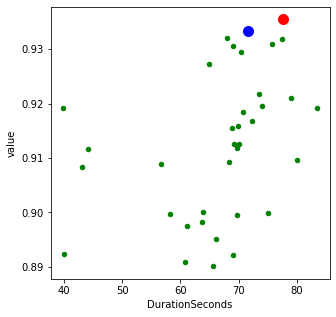

In [19]:
ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [71]:
featureHeadersTest = featureHeaders[:]
#featureHeadersTest.remove("Segment_eccentricity")
#featureHeadersTest.remove("Segment_perimeter")
#featureHeadersTest = [f for f in featureHeadersTest if "Sigma5" not in f and "Sentinel2_B0" not in f]
#featureHeadersTest = [f for f in featureHeadersTest if "Sentinel2_B0" not in f]
#featureHeadersTest


In [23]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.01, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 26, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 24.47, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 15, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 2.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 15, 
                           'Impervious': 7, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 10} # dropping to 8 from 14.88 on 2021-08-28

# replace human readable names with numerical associations
local_class_weight_dict = { values_2019_lookup[k]: v/100 for k, v in local_class_weight_dict.items() }
print(sum(local_class_weight_dict.values()))

1.0000000000000002


In [20]:
trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

sampsize = min(10**5, trainingSamples.LCClassInt.value_counts().min())
overwrite=False
modelTrainingData_loc = f"../OtherData/TrainingData/ModelTrainingGroup_{sampsize}.pickle"
if not os.path.exists(modelTrainingData_loc) or overwrite:
    subSampForFit = getSubSample(data=trainingSamples, maxSampSize=sampsize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
    subSampForFit["RGBNmean"] = subSampForFit.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    subSampForFit["geometry"] = subSampForFit.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
    for files_dict in [sentinel_bands, sentinel_indicies]:
        for name, file in files_dict.items():
            column_name = f"{sentinel_prefix}{name}"
            print(f"Working {column_name}")
            with rio.open(file) as src:
                subSampForFit[column_name] = subSampForFit["geometry"].swifter.apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                
    #gpd.GeoDataFrame(subSampForFit, geometry="geometry", crs="epsg:2868").to_file(modelTrainingData_loc, driver="GPKG")
    del subSampForFit["X"], subSampForFit["Y"], subSampForFit["geometry"]
    subSampForFit.to_pickle(modelTrainingData_loc)

In [11]:
import chime
chime.theme("zelda")
chime.success()

Reading in training data for final model...


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.7670933560785981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7670933560785981
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.6559554252479768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6559554252479768
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's F1: 0.82235
Model:
	Accuracy: 0.8209288888888889
	F1: 0.8223495382034565
	CohensKappa: 0.7985091278322729
               precision    recall  f1-score   support

     PondLake       0.90      0.40      0.56  

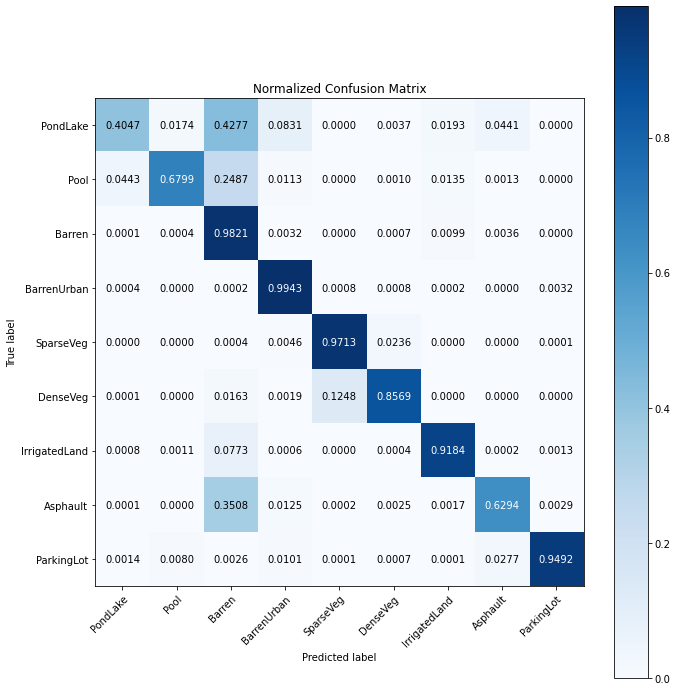

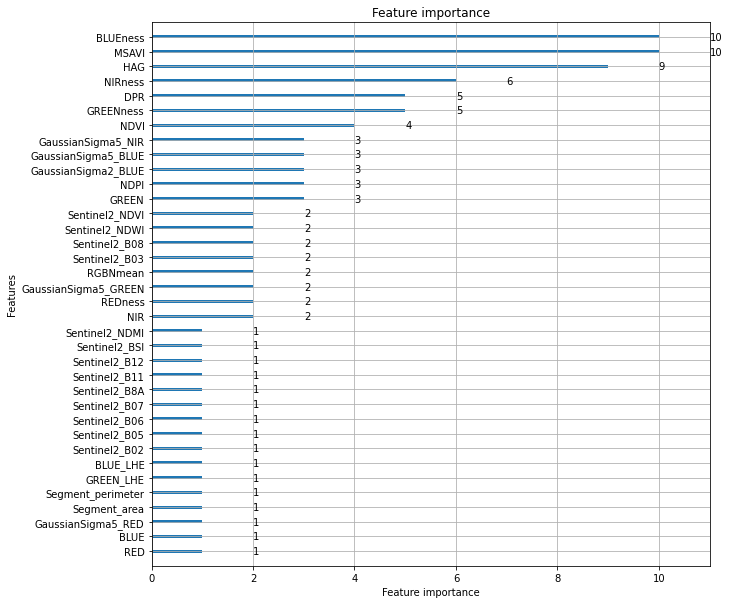

In [28]:
%%time

trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

sampsize = min(10**5, trainingSamples.LCClassInt.value_counts().min())
overwrite = False
modelTrainingData_loc = f"../OtherData/TrainingData/ModelTrainingGroup_{sampsize}.pickle"
if not os.path.exists(modelTrainingData_loc) or overwrite:
    subSampForFit = getSubSample(data=trainingSamples, maxSampSize=sampsize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
    subSampForFit["RGBNmean"] = subSampForFit.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    subSampForFit["geometry"] = subSampForFit.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
    for files_dict in [sentinel_bands, sentinel_indicies]:
        for name, file in files_dict.items():
            column_name = f"{sentinel_prefix}{name}"
            print(f"Working {column_name}")
            with rio.open(file) as src:
                subSampForFit[column_name] = subSampForFit["geometry"].swifter.apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                
    #gpd.GeoDataFrame(subSampForFit, geometry="geometry", crs="epsg:2868").to_file(modelTrainingData_loc, driver="GPKG")
    del subSampForFit["X"], subSampForFit["Y"], subSampForFit["geometry"]
    subSampForFit.to_pickle(modelTrainingData_loc)
else:
    print("Reading in training data for final model...")
    subSampForFit = pd.read_pickle(modelTrainingData_loc)

trainingFeaturesToUse = subSampForFit.columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")
#subSampForFit = pd.concat(subGroups)#[0].copy()
final_optimum_params = {**fixed_params, **optimum_params}
final_optimum_params["early_stopping_rounds"] = 200
#final_optimum_params["min_data_in_leaf"] = int(0.005*(len(subSampForFit)/9))
#final_optimum_params["class_weight"] = local_class_weight_dict
#final_optimum_params["num_boost_round"] = 300
#featureHeaders = list(set(featureHeaders :=featureHeaders+["RGBNmean"]))
optimumlgbm_model, scores = buildModel(final_optimum_params, subSampForFit, trainingFeaturesToUse, class_col, fullReport=True, writeOut=True, verbosity=-1, suffix="optimum")
lgb.plot_importance(optimumlgbm_model, figsize=(10,10))
%chime

With num_boost_rounds at 200

- Accuracy: 0.9639288888888888
- F1: 0.9639342783938613
- CohensKappa: 0.9594186223091214

In [95]:
from pprint import pprint
with rio.open(r"M:\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W1004789_W449850_TrainingStackV3_MultiClassOptunaTunerGBLM_20211103.tif") as src:
    t = src.read(1)

uniques, counts = np.unique(t, return_counts=True) 
tt = dict(zip(uniques, counts))

pprint({k:round(100*vv/sum(counts),2) for kk,vv in  tt.items() for k,v in values_2019_lookup.items() if v ==kk})

{'Asphault': 21.76,
 'Barren': 6.63,
 'DenseVeg': 19.74,
 'Impervious': 18.44,
 'IrrigatedLand': 2.1,
 'ParkingLot': 21.76,
 'PondLake': 0.36,
 'Pool': 1.5,
 'Sidewalk': 18.44,
 'SparseVeg': 6.11,
 'Structure': 23.36}


In [41]:
#pickle.loads(open(, "rb"))
tm = pickle.load(open(r"M:\PAG2019\notebooks\Models\lightGBM_20211029_optimum.sav", 'rb'))
tm.predict_proba

<bound method LGBMClassifier.predict_proba of LGBMClassifier(bagging_fraction=0.75, bagging_freq=5, boosting_type='gbdt',
               class_weight={1: 0.005, 2: 0.025, 3: 42, 4: 25, 5: 10.47, 6: 0.5,
                             7: 11, 8: 3, 9: 8},
               colsample_bytree=1.0, early_stopping_rounds=40,
               feature_fraction=0.9588517713840665, importance_type='split',
               learning_rate=0.0523915237080851, max_depth=29, metric='custom',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=1000, min_split_gain=0.01, n_estimators=317,
               n_jobs=8, num_boost_round=224, num_leaves=484,
               objective='multiclass', random_state=7,
               reg_alpha=0.08315960386554257, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)>

In [85]:
chime.success()

In [45]:
%%time
# Green Leaf Index
subSampForFit["GLI"] = subSampForFit.swifter.apply(lambda r: ((r.GREEN-r.RED)+(r.GREEN+r.BLUE))/((2*r.GREEN)+r.RED+r.BLUE), axis=1)


Wall time: 5min 7s


In [ ]:
# Bare Soil Index Sentinel 2 MSI = ((BAND11+BAND4)-(BAND8+BAND2))/((BAND11+BAND4)+(BAND8+BAND2))
# Bare Soil Index Landsat 8 OLI = ((BAND6+BAND4)-(BAND5+BAND2))/((BAND6+BAND4)+(BAND5+BAND2))

[LightGBM] [Warning] feature_fraction is set=0.7676168890994449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7676168890994449
[LightGBM] [Warning] min_data_in_leaf is set=34543, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34543
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=40, early_stopping_rounds=40 will be ignored. Current value: early_stopping_round=40
[LightGBM] [Warning] num_iterations is set=225, num_boost_round=225 will be ignored. Current value: num_iterations=225
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[36]	valid_0's F1: 0.948163
Model:
	Accuracy: 0.9505099805657359
	F1: 0.9481633418621609
	CohensKappa: 0.9443239110949098
               preci

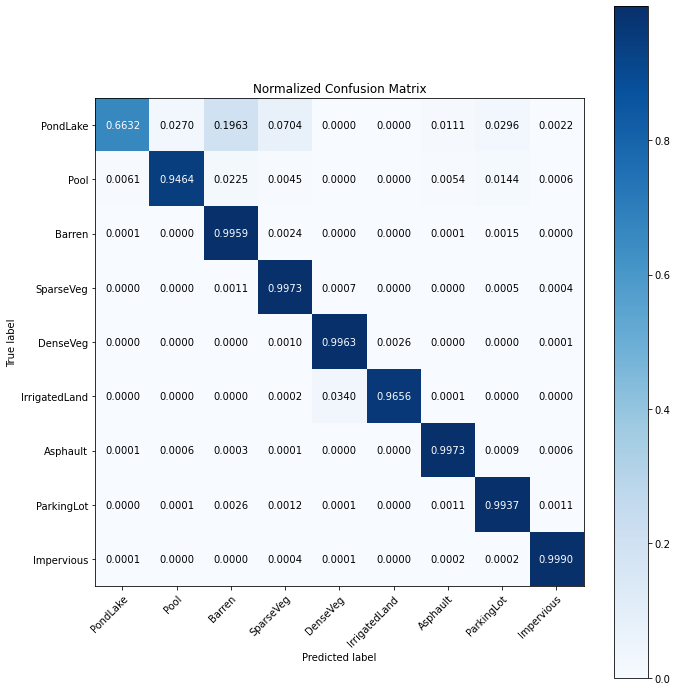

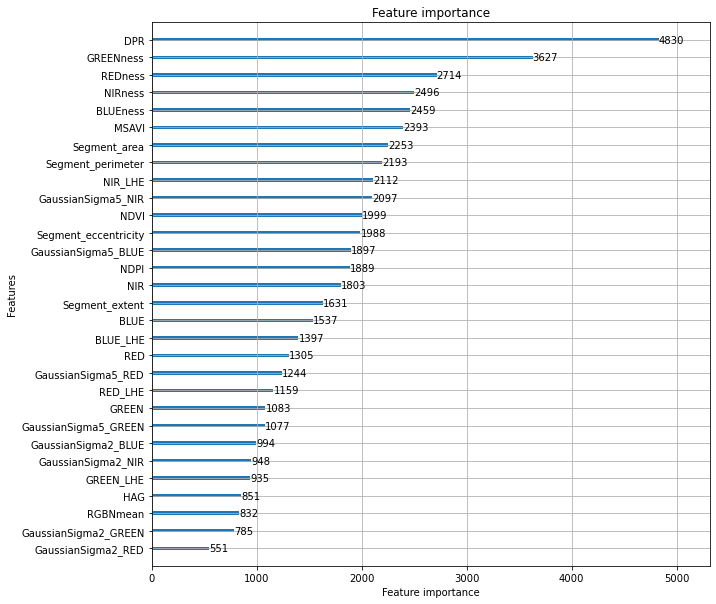

In [39]:
%%time
sampsize = min(10**7, trainingSamples.LCClassInt.value_counts().min())
subSampForFit = getSubSample(data=trainingSamples, maxSampSize=sampsize, features_cols=trainingFeaturesToUse, class_column=class_col)
subSampForFit["RGBNmean"] = subSampForFit.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)

best_featureHeaders = list(set(featureHeaders+["RGBNmean"]))
#best_featureHeaders = [FH for FH in best_featureHeaders if not FH.startswith("Segment_")]
final_best_params = {**fixed_params, **best_params}
final_best_params["min_data_in_leaf"] = int(0.01*sampsize)
bestlgbm_model, scores = buildModel(final_best_params, subSampForFit, best_featureHeaders, class_col, fullReport=True, writeOut=True, verbosity=-1, suffix="best")
lgb.plot_importance(bestlgbm_model, figsize=(10,10))

In [40]:
finished()

## 5/19 Best Model

In [66]:
best_performers = history[(history.value>(best_score-0.03)) & (history.DurationSeconds < 180)]
highestAccuracy = history[history.value == history.value.max()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value > best_score * 0.95)]
optimum_trial = best_performers[best_performers.value == best_performers.value.max()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {optimum_time%60} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

Optimum trial (#14): 
	score 0.9457121900889948 
	took 1 minutes 53.977389 seconds 
	params: {
          "feature_fraction": 0.45147944998417966,
          "bagging_fraction": 0.4949143006815773,
          "num_leaves": 208,
          "max_depth": 27,
          "learning_rate": 0.05413473489373892,
          "num_boost_round": 50,
          "boosting_type": "gbdt",
          "n_estimators": 167
}


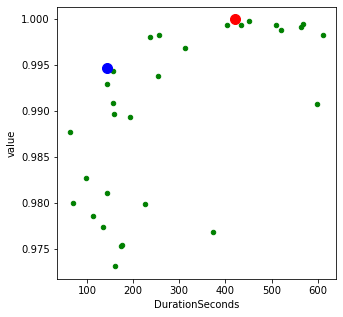

In [31]:
ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [30]:
final_best_params = {**fixed_params, **best_params}

[36]	valid_0's multi_logloss: 0.468567
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[37]	valid_0's multi_logloss: 0.464455
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 27

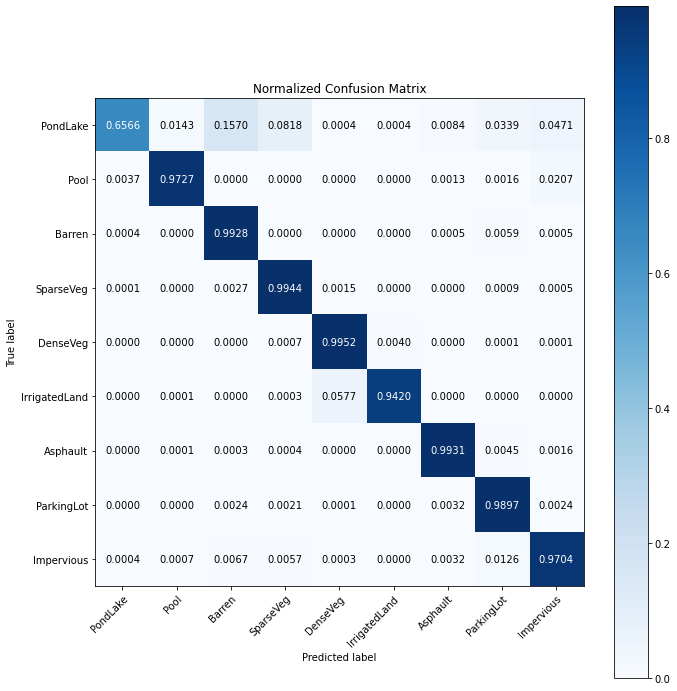

In [76]:
%%time
final_optimum_params = {**fixed_params, **optimum_params}
optimumlgbm_model = buildBestModel(final_optimum_params, pd.concat(subGroups))

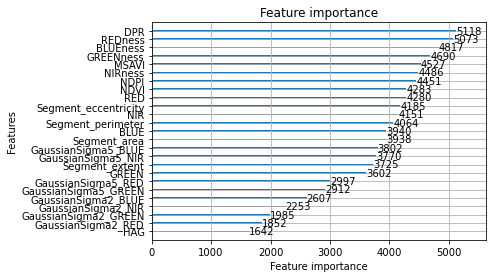

In [77]:
lgb.plot_importance(optimumlgbm_model)

In [401]:
%chime 